In [1]:
## load dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import scipy
import os, pickle, csv
from src import utils
from src.ModelTree import DevelopModel

In [10]:
# ====================
# Settings
# ====================
mode = "regr"  # "clf" / "regr"
save_model_tree = True  # save model tree?
save_model_tree_predictions = True  # save model tree predictions/explanations?
cross_validation = True  # cross-validate model tree?

# read data 
df = utils.read_data('data2','excel')

# split data to train and test
df_train, df_test = train_test_split(df, test_size=0.20, random_state=42)

In [11]:
utils.stat_describe(df)

,CEM,WCC,WFA,WPP,Sand,NA,RA,Super,Water,Slump,Days,Cycle,RV,UPV,Strength
count,126.00,126.00,126.00,126.00,126.00,126.00,126.00,126.00,126.0,126.00,126.00,126.00,126.00,126.00,126.00
mean,403.57,32.14,32.14,32.14,765.29,678.86,215.52,2.60,175.0,65.47,278.00,33.33,44.78,4351.97,76.03
std,52.70,54.85,54.85,54.85,10.94,193.70,177.62,0.80,0.0,5.75,228.75,55.50,6.40,462.96,16.39
min,350.00,0.00,0.00,0.00,750.00,451.00,0.00,1.50,175.0,57.50,28.00,0.00,25.00,1387.00,15.96
25%,350.00,0.00,0.00,0.00,751.00,464.00,0.00,1.70,175.0,60.00,90.00,0.00,41.00,4285.00,66.10
50%,425.00,0.00,0.00,0.00,766.00,690.00,225.00,3.00,175.0,65.50,270.00,0.00,45.00,4481.50,79.00
75%,425.00,75.00,75.00,75.00,774.00,901.00,442.00,3.25,175.0,72.00,270.00,50.00,48.00,4585.50,86.98
max,500.00,150.00,150.00,150.00,783.00,939.00,460.00,3.75,175.0,73.50,740.00,150.00,59.00,5004.00,100.00
variation coef.,0.13,1.70,1.70,1.70,0.01,0.28,0.82,0.31,0.0,0.09,0.82,1.66,0.14,0.11,0.21
skewness coef.,0.46,1.36,1.36,1.36,-0.03,0.09,0.06,-0.10,0.0,0.07,1.08,1.43,-0.32,-3.08,-1.22


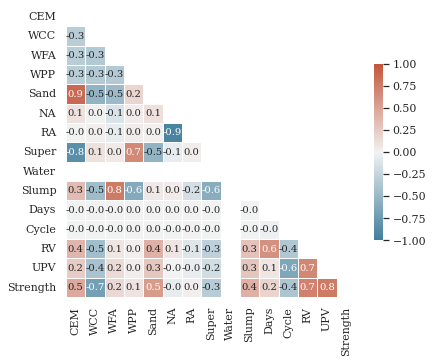

In [4]:
utils.plot_corr_heatmap(df,'corr_heatmap_data2.jpg')

In [13]:
from src import utils
# separate X and y in train and test
X_train, y_train, header = utils.load_df_data(df_train)
X_test, y_test, header = utils.load_df_data(df_test)

# scale the data
X_train_scaled, X_test_scaled = utils.scale_data(X_train, X_test)



In [7]:
# regression tree
test = DevelopModel('DecisionTree', model_tree=False)
test.fit(X_train, y_train, verbose=False)
test.evaluate(X_test, y_test)
test.save_output(X_train, y_train, X_test, y_test)
# test.export_graph(header)
test.save_model()
test.cross_validate(X_train, y_train, kfold=5, seed=13)
test.save_model


DecisionTree loss for test data is 94.5229411920087
DecisionTree r2 for test data is 0.6717780028910403
DecisionTree pearsonr for test data is 0.8339197338305245

Cross-validating (kfold=5, seed=13)...
 [fold 1/5] loss_train=68.6425, loss_validation=111.755
 [fold 1/5] r2_train=0.756263, r2_validation=0.350315
 [fold 1/5] pearson_train=0.869634, pearson_validation=0.708255
 [fold 2/5] loss_train=89.5089, loss_validation=157.405
 [fold 2/5] r2_train=0.615519, r2_validation=0.510749
 [fold 2/5] pearson_train=0.78455, pearson_validation=0.754852
 [fold 3/5] loss_train=93.146, loss_validation=101.617
 [fold 3/5] r2_train=0.648673, r2_validation=0.533062
 [fold 3/5] pearson_train=0.805403, pearson_validation=0.734624
 [fold 4/5] loss_train=72.2193, loss_validation=144.857
 [fold 4/5] r2_train=0.726107, r2_validation=0.417576
 [fold 4/5] pearson_train=0.852119, pearson_validation=0.698828
 [fold 5/5] loss_train=82.2202, loss_validation=162.602
 [fold 5/5] r2_train=0.678769, r2_validation=0.

<bound method DevelopModel.save_model of <src.ModelTree.DevelopModel object at 0x7fc30217ab50>>

In [34]:
def sensitivity_analysis(model:object, X_train:np.array):
    # function to give a np.array of the sensitivity of each feature
    changes = list(range(-50, 51, 10))
    y = model.predict(X_train)
    results = []
    for i in range(X_train.shape[1]):
        results.append([])
        for j in changes:
            X_train_copy = X_train.copy()
            X_train_copy[:, i] = X_train_copy[:, i] * (1 + j/100)
            y_pred = model.predict(X_train_copy)
            # average of y_pred numpy array
            results[i].append(((y_pred - y).mean()) / y.mean() * 100)
    return results
def uncertainty_analysis (model:object, X:np.array, y:np.array) -> None:
    # function to give a np.array of the uncertainty of each feature
    y_pred = model.predict(X)

    err = y - y_pred
    err_mean = err.mean()
    err_std = err.std()
    print(f'mean error is {err_mean}')
    print(f'95% uncertainty bandwidth is {1.96 * err_std}')
    print(f'95% interval starts from {err_mean - 1.96 * err_std} and ends at {err_mean + 1.96 * err_std}')
    return 

In [35]:
uncertainty_analysis(test.model, X_train, y_train)


mean error is 0.7823164831773377
95% uncertainty bandwidth is 13.578883239485064
95% interval starts from -12.796566756307726 and ends at 14.361199722662402


In [30]:
# gp alone
test = DevelopModel('gaussianprocess', model_tree=False)
test.fit(X_train, y_train, verbose=False)
test.evaluate(X_test, y_test)
test.save_output(X_train, y_train, X_test, y_test)
# test.export_graph(header)
test.save_model()
test.cross_validate(X_train, y_train, kfold=5, seed=13)
test.save_model


gaussianprocess loss for test data is 47.50613348854077
gaussianprocess r2 for test data is 0.8350394326298013
gaussianprocess pearsonr for test data is 0.915568530873265

Cross-validating (kfold=5, seed=13)...
 [fold 1/5] loss_train=39.3989, loss_validation=113.28
 [fold 1/5] r2_train=0.860102, r2_validation=0.341446
 [fold 1/5] pearson_train=0.927417, pearson_validation=0.74498
 [fold 2/5] loss_train=47.8189, loss_validation=46.1811
 [fold 2/5] r2_train=0.794596, r2_validation=0.856459
 [fold 2/5] pearson_train=0.891401, pearson_validation=0.958807
 [fold 3/5] loss_train=44.1721, loss_validation=60.944
 [fold 3/5] r2_train=0.833392, r2_validation=0.719959
 [fold 3/5] pearson_train=0.912905, pearson_validation=0.854624
 [fold 4/5] loss_train=49.1747, loss_validation=43.1823
 [fold 4/5] r2_train=0.813504, r2_validation=0.826377
 [fold 4/5] pearson_train=0.901945, pearson_validation=0.925132
 [fold 5/5] loss_train=38.1435, loss_validation=90.472
 [fold 5/5] r2_train=0.850975, r2_valida

<bound method DevelopModel.save_model of <src.ModelTree.DevelopModel object at 0x7fc3020ca790>>

In [14]:
# gp + model tree
test = DevelopModel('gaussianprocess', model_tree=True)
test.fit(X_train, y_train, verbose=False)
test.evaluate(X_test, y_test)
test.save_output(X_train, y_train, X_test, y_test)
# test.export_graph(header)
test.save_model()
test.cross_validate(X_train, y_train, kfold=5, seed=13, )
test.save_model


m5p_gaussianprocess_tree loss for test data is 31.853803500764666
m5p_gaussianprocess_tree r2 for test data is 0.8893906720560102
m5p_gaussianprocess_tree pearsonr for test data is 0.9440739929019216

Cross-validating (kfold=5, seed=13)...
 [fold 1/5] loss_train=13.1755, loss_validation=13.8946
 [fold 1/5] r2_train=0.953216, r2_validation=0.919224
 [fold 1/5] pearson_train=0.976335, pearson_validation=0.959916
 [fold 2/5] loss_train=14.0765, loss_validation=10.2907
 [fold 2/5] r2_train=0.939535, r2_validation=0.968014
 [fold 2/5] pearson_train=0.969557, pearson_validation=0.986867
 [fold 3/5] loss_train=12.9037, loss_validation=14.9817
 [fold 3/5] r2_train=0.95133, r2_validation=0.931158
 [fold 3/5] pearson_train=0.975464, pearson_validation=0.966145
 [fold 4/5] loss_train=13.7922, loss_validation=11.428
 [fold 4/5] r2_train=0.947693, r2_validation=0.954052
 [fold 4/5] pearson_train=0.973535, pearson_validation=0.977338
 [fold 5/5] loss_train=12.6487, loss_validation=16.0017
 [fold 5/

<bound method DevelopModel.save_model of <src.ModelTree.DevelopModel object at 0x7fc20403d580>>

In [9]:
# svm alone
test = DevelopModel('svm', model_tree=False)
test.fit(X_train, y_train, verbose=False)
test.evaluate(X_test, y_test)
test.save_output(X_train, y_train, X_test, y_test)
# test.export_graph(header)
test.save_model()
test.cross_validate(X_train, y_train, kfold=5, seed=13, )
test.save_model


svm loss for test data is 287.16555769572125
svm r2 for test data is 0.002844688715987864
svm pearsonr for test data is 0.8423705755838052

Cross-validating (kfold=5, seed=13)...
 [fold 1/5] loss_train=274.548, loss_validation=200.011
 [fold 1/5] r2_train=0.0251325, r2_validation=-0.162759
 [fold 1/5] pearson_train=0.835957, pearson_validation=0.621036
 [fold 2/5] loss_train=227.7, loss_validation=407.485
 [fold 2/5] r2_train=0.0219254, r2_validation=-0.266555
 [fold 2/5] pearson_train=0.738276, pearson_validation=0.911983
 [fold 3/5] loss_train=252.464, loss_validation=208.265
 [fold 3/5] r2_train=0.0477589, r2_validation=0.0430117
 [fold 3/5] pearson_train=0.794608, pearson_validation=0.823005
 [fold 4/5] loss_train=254.935, loss_validation=236.033
 [fold 4/5] r2_train=0.0331534, r2_validation=0.0509846
 [fold 4/5] pearson_train=0.786195, pearson_validation=0.828743
 [fold 5/5] loss_train=243.027, loss_validation=246.976
 [fold 5/5] r2_train=0.0505006, r2_validation=0.0747358
 [fold

<bound method DevelopModel.save_model of <src.ModelTree.DevelopModel object at 0x7fc141ecf670>>